## __Jax, Flax, Optax__

### __jax.numpy__

- numpyと同様に配列を操作できる

In [1]:
import jax.numpy as jnp

In [2]:
a = jnp.array([
    [1, 2, 3],
    [4, 5, 6],
])

a

Array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)

In [3]:
a.shape

(2, 3)

In [4]:
a.dtype

dtype('int32')

### __乱数生成__

- numpyとは異なり乱数のシードは変数(状態変数)で指定する

- デフォルトはfloat32であることに注意

In [5]:
import jax

key = jax.random.key(0)
key

Array((), dtype=key<fry>) overlaying:
[0 0]

In [6]:
# 乱数生成のキーは1度しか使えないため、使用する用と保存するように分割する
key, _ = jax.random.split(key)

In [7]:
random_array = jax.random.normal(key, (10000,))
random_array

Array([ 0.19083706,  0.2970768 ,  1.7548186 , ...,  0.41046736,
       -0.15044403,  0.8289169 ], dtype=float32)

### __自動微分__

jax.grad関数で勾配を計算できる

In [8]:
def square(x):
    return x ** 2

# 勾配を返す関数
grad_square = jax.grad(square)
grad_square

<function __main__.square(x)>

In [9]:
# 勾配を計算
grad_square(2.0)

Array(4., dtype=float32, weak_type=True)

### __vmap__

In [10]:
vectorized_square = jax.vmap(square)
vectorized_square

<function __main__.square(x)>

In [11]:
# vmapを使う場合
%%time
vectorized_square(random_array)

CPU times: user 43.3 ms, sys: 315 µs, total: 43.6 ms
Wall time: 142 ms


Array([0.03641878, 0.08825462, 3.0793881 , ..., 0.16848345, 0.02263341,
       0.6871032 ], dtype=float32)

In [12]:
# vmapを使わない場合
%%time
jnp.array([square(x) for x in random_array])

CPU times: user 5.3 s, sys: 277 ms, total: 5.57 s
Wall time: 13.9 s


Array([0.03641878, 0.08825462, 3.0793881 , ..., 0.16848345, 0.02263341,
       0.6871032 ], dtype=float32)

### __Flax__

In [13]:
import flax.linen as nn

# モデルの構造定義
# modelはモデルのパラメータを保持しない
# featuresに出力次元を定義する
# 入力次元は入力データから計算される
model = nn.Dense(features=3)
model

Dense(
    # attributes
    features = 3
    use_bias = True
    dtype = None
    param_dtype = float32
    precision = None
    kernel_init = init
    bias_init = zeros
    dot_general = None
    dot_general_cls = None
)

In [14]:
# パラメータの初期化
key = jax.random.PRNGKey(0)
key, model_init_key = jax.random.split(key)

# 入力次元数を与えるためにダミーの入力データを作成する
dummy_input = jnp.ones((1, 5))
dummy_input

params = model.init(model_init_key, dummy_input)
params

{'params': {'kernel': Array([[ 0.26148954, -0.6129929 , -0.23358513],
         [ 0.11150402, -0.8755793 ,  0.9810635 ],
         [ 0.36360955,  0.18376349, -0.68460613],
         [-0.8509373 , -0.64067173, -0.48081222],
         [-0.6876102 , -0.33887318, -0.05798903]], dtype=float32),
  'bias': Array([0., 0., 0.], dtype=float32)}}

In [15]:
params["params"]["kernel"]

Array([[ 0.26148954, -0.6129929 , -0.23358513],
       [ 0.11150402, -0.8755793 ,  0.9810635 ],
       [ 0.36360955,  0.18376349, -0.68460613],
       [-0.8509373 , -0.64067173, -0.48081222],
       [-0.6876102 , -0.33887318, -0.05798903]], dtype=float32)

In [16]:
params["params"]["bias"]

Array([0., 0., 0.], dtype=float32)

In [17]:
# 推論
# モデル内部にある(はずの)paramsと入力データxを与えて推論できる
model.apply(params, dummy_input)

Array([[-0.8019444 , -2.2843535 , -0.47592902]], dtype=float32)

### __最適化関数__

- optaxライブラリで実装されている

- transformationの略であるtxという変数名がよく使われる

- optimizer内部の状態は外部の変数として扱う

In [18]:
import optax

# optimizer
# txとはtransformationの略
tx = optax.sgd(learning_rate=0.1, momentum=0.9)
tx

GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7b35d490a7a0>, update=<function chain.<locals>.update_fn at 0x7b35d490a950>)

In [19]:
# optimizerの内部状態
opt_state = tx.init(params)
opt_state

(TraceState(trace={'params': {'bias': Array([0., 0., 0.], dtype=float32), 'kernel': Array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=float32)}}),
 EmptyState())

### __損失関数__

- optaxライブラリで実装されている

In [20]:
# 損失関数の例

# ダミーの入力
pred = model.apply(params, dummy_input)
y = jnp.array([[1.0, 2.0, 3.0]])

# これは単純に要素ごとに誤差の2乗を計算するので、それを後で平均する必要がある
optax.l2_loss(pred, y)

Array([[1.6235018, 9.177841 , 6.0410414]], dtype=float32)

In [21]:
# 損失関数

def loss_fn(params, x, y):
    # 推論
    pred = model.apply(params, x)

    # 損失
    loss = optax.l2_loss(pred, y).mean()

    return loss

### __勾配関数__

関数$f$の勾配は以下の式で求まる

$$
∇f(x) = (\frac{∂f}{∂x_1}, \frac{∂f}{∂x_2}, ... \frac{∂f}{∂x_n})
$$

`jax.value_and_grad`関数は関数$f$を入力として、以下のような関数$g$を返す

$$
g(x)=(f(x),∇f(x))
$$

関数$f$を損失関数とすれば、モデルのパラメータを変更する際に必要となる勾配が求まる

In [22]:
value_grad_fn = jax.value_and_grad(loss_fn)
value_grad_fn

<function __main__.loss_fn(params, x, y)>

### __学習__

TrainStateを使わずに素で書いた場合、3つのステップで学習を行う


1. 損失と勾配を計算

2. 最適化関数に従ってパラメータの更新量を計算

3. パラメータを更新

In [23]:
# サンプルデータの作成
n_samples = 20
x_dim = 5
y_dim = 3
y_std = 0.1

key_w, key_b, key_sample, key_noise, _ = jax.random.split(_, 5)
x_sample = jax.random.normal(key_sample, (n_samples, x_dim))

W = jax.random.normal(key_w, (x_dim, y_dim))
b = jax.random.normal(key_b, (y_dim,))

y_noise = jax.random.normal(key_noise, (n_samples, y_dim))
y_sample = jnp.dot(x_sample, W) + b + y_std * y_noise

In [24]:
loss_history = []

for i in range(100):
    # ① 勾配と損失を計算
    loss, grads = value_grad_fn(params, x_sample, y_sample)

    # ② 最適化関数に従ってパラメータの更新量(updates)を計算
    updates, opt_state = tx.update(grads, opt_state)

    # ③ パラメータを更新
    params = optax.apply_updates(params, updates)

    loss_history.append(loss.item())

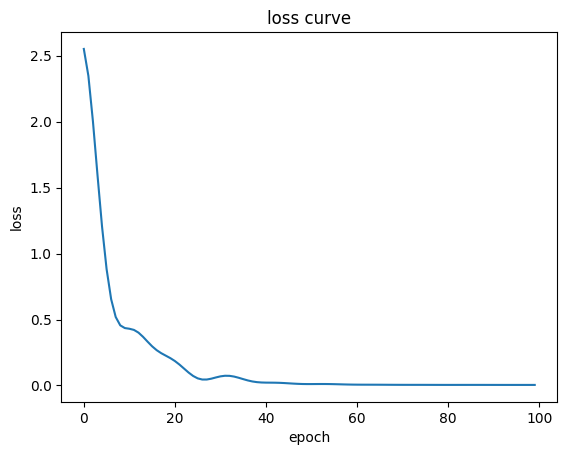

In [25]:
from matplotlib import pyplot as plt

plt.plot(loss_history)
plt.title("loss curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

### __モデルIO__

In [26]:
import flax

bytes_save = flax.serialization.to_bytes(params)
bytes_save

b"\x81\xa6params\x82\xa4bias\xc7\x19\x01\x93\x91\x03\xa7float32\xc4\x0c7/\xa1\xbfJ\xc7\n\xc0\x0c\xa1\x0b?\xa6kernel\xc7J\x01\x93\x92\x05\x03\xa7float32\xc4<\xd8\xa9\xb5?\x8ae'\xbf.\x001\xbfI\xe7\xc5>+\xce\x1c=\xb8:\x02>\xce\xfc\x9b\xbe3\xd4^?^\x90\xab\xbe\x0c\xc9n?\t\xb3\xb9>\x9c\xd7}=\x1a\xf2\x98\xbf\xee\x86\x16\xc0H'3?"

In [27]:
# モデルの保存
with open("params.bin", "wb") as f:
    f.write(bytes_save)

In [28]:
# モデルの読み込み
with open("params.bin", "rb") as f:
    bytes_load = f.read()

flax.serialization.from_bytes(params, bytes_load)

{'params': {'bias': array([-1.2592534 , -2.1684136 ,  0.54542613], dtype=float32),
  'kernel': array([[ 1.4192457 , -0.6538931 , -0.691409  ],
         [ 0.3865302 ,  0.03828255,  0.12717712],
         [-0.30466312,  0.8704254 , -0.3350858 ],
         [ 0.93275523,  0.36269405,  0.0619732 ],
         [-1.1948884 , -2.3519855 ,  0.69981813]], dtype=float32)}}

### __TrainState__

TrainStateのメリット

- モデルや最適化関数の内部状態を簡単に管理できる

In [29]:
from flax.training.train_state import TrainState

params = model.init(model_init_key, dummy_input)
tx = optax.sgd(learning_rate=0.1, momentum=0.9)

state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=tx,
)
state

TrainState(step=0, apply_fn=<bound method Module.apply of Dense(
    # attributes
    features = 3
    use_bias = True
    dtype = None
    param_dtype = float32
    precision = None
    kernel_init = init
    bias_init = zeros
    dot_general = None
    dot_general_cls = None
)>, params={'params': {'kernel': Array([[ 0.26148954, -0.6129929 , -0.23358513],
       [ 0.11150402, -0.8755793 ,  0.9810635 ],
       [ 0.36360955,  0.18376349, -0.68460613],
       [-0.8509373 , -0.64067173, -0.48081222],
       [-0.6876102 , -0.33887318, -0.05798903]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7b35d3824d30>, update=<function chain.<locals>.update_fn at 0x7b35d3824dc0>), opt_state=(TraceState(trace={'params': {'bias': Array([0., 0., 0.], dtype=float32), 'kernel': Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)}}), EmptyState(

In [30]:
state.params

{'params': {'kernel': Array([[ 0.26148954, -0.6129929 , -0.23358513],
         [ 0.11150402, -0.8755793 ,  0.9810635 ],
         [ 0.36360955,  0.18376349, -0.68460613],
         [-0.8509373 , -0.64067173, -0.48081222],
         [-0.6876102 , -0.33887318, -0.05798903]], dtype=float32),
  'bias': Array([0., 0., 0.], dtype=float32)}}

In [31]:
state.tx

GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7b35d3824d30>, update=<function chain.<locals>.update_fn at 0x7b35d3824dc0>)

In [32]:
state.apply_fn

<bound method Module.apply of Dense(
    # attributes
    features = 3
    use_bias = True
    dtype = None
    param_dtype = float32
    precision = None
    kernel_init = init
    bias_init = zeros
    dot_general = None
    dot_general_cls = None
)>

In [33]:
@jax.jit
def train_step(state, batch: dict):

    # ①
    loss, grads = value_grad_fn(state.params, batch["x"], batch["y"])

    # ②と③をまとめた関数
    state = state.apply_gradients(grads=grads)
    return state, loss

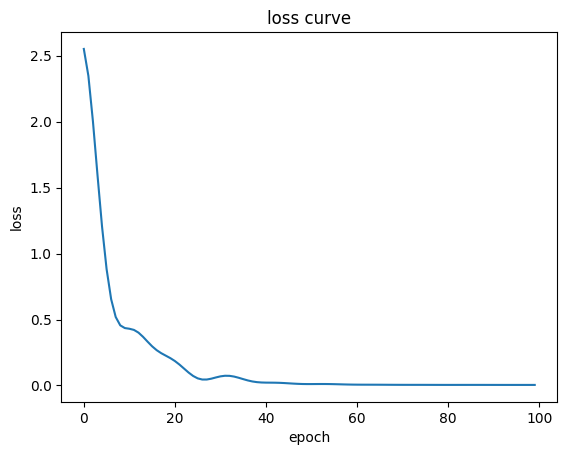

In [34]:
loss_history = []

# 簡単のために全データで学習
batch = {"x": x_sample, "y": y_sample}
for i in range(100):
    state, loss = train_step(state, batch)
    loss_history.append(loss.item())

# 学習曲線
plt.plot(loss_history)
plt.title("loss curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()